In [40]:
from configparser import ConfigParser
from sqlalchemy import create_engine
import pandas as pd
#import pandas_profiling
from ua_parser import user_agent_parser
from geolite2 import geolite2
import geopandas as gpd
import pycountry
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.8)   
from pandas.api.types import is_numeric_dtype


def read_db_config(filename='config-dump.ini', section='mysql'):
    """ Read database configuration file and return a dictionary object
    :param filename: name of the configuration file
    :param section: section of database configuration
    :return: a dictionary of database parameters
    """
    # create parser and read ini configuration file
    parser = ConfigParser()
    parser.read(filename)
 
    # get section, default to mysql
    db = {}
    if parser.has_section(section):
        items = parser.items(section)
        for item in items:
            db[item[0]] = item[1]
    else:
        raise Exception('{0} not found in the {1} file'.format(section, filename))
 
    return db

dbconfig = read_db_config()
CONN = 'mysql+mysqlconnector://'+dbconfig['user']+':'+dbconfig['pwd']+'@'+dbconfig['host']+':'+dbconfig['port'] + '/'+dbconfig['dbname']
engine = create_engine(CONN)

# Supress scientific notation 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Final ITE update 

In [ ]:
ALTER TABLE VALID_INPUT_LOGDATA ADD COLUMN INPUT_LEN INT;
ALTER TABLE VALID_INPUT_LOGDATA ADD COLUMN INPUT_LDIST INT;
ALTER TABLE VALID_INPUT_LOGDATA ADD COLUMN INPUT_PRLEN INT;
ALTER TABLE VALID_INPUT_LOGDATA ADD COLUMN INPUT_PRLDIST INT;
ALTER TABLE VALID_INPUT_LOGDATA ADD COLUMN ITE_SWYP INT;
ALTER TABLE VALID_INPUT_LOGDATA ADD COLUMN ITE_PRED INT;
ALTER TABLE VALID_INPUT_LOGDATA ADD COLUMN ITE_AUTO INT;


In [ ]:
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN N_SWYP INT;
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN N_PRED INT;
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN N_AUTO INT;
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN PR_SWYP DOUBLE;
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN PR_PRED DOUBLE;
ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN PR_AUTO DOUBLE;

ALTER TABLE VALID_PARTICIPANTS ADD COLUMN ITE_SWYPE DOUBLE;
ALTER TABLE VALID_PARTICIPANTS ADD COLUMN ITE_PREDICT DOUBLE;
ALTER TABLE VALID_PARTICIPANTS ADD COLUMN ITE_AUTOCORR DOUBLE;

ALTER TABLE FIRST_15_TEST_SECTIONS ADD COLUMN TS_NUM_WORDS DOUBLE; 


## Split by 4k chunks

In [ ]:
CREATE TABLE SAMPLE_PARTICIPANTS_1 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_1 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 0, 4000;

CREATE TABLE SAMPLE_PARTICIPANTS_2 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_2 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 4000, 4000;

CREATE TABLE SAMPLE_PARTICIPANTS_3 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_3 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 8000, 4000;

CREATE TABLE SAMPLE_PARTICIPANTS_4 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_4 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 12000, 4000;

CREATE TABLE SAMPLE_PARTICIPANTS_5 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_5 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 16000, 4000;

CREATE TABLE SAMPLE_PARTICIPANTS_6 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_6 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 20000, 4000;
    
CREATE TABLE SAMPLE_PARTICIPANTS_7 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_7 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 24000, 4000;
    
CREATE TABLE SAMPLE_PARTICIPANTS_8 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_8 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 28000, 4000;
    
CREATE TABLE SAMPLE_PARTICIPANTS_9 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_9 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 32000, 4000;
    
CREATE TABLE SAMPLE_PARTICIPANTS_10 LIKE VALID_PARTICIPANTS;
INSERT INTO SAMPLE_PARTICIPANTS_10 
    SELECT * FROM VALID_PARTICIPANTS LIMIT 32000, 6000;


## Compute for every chunk (change SAMPLE_PARTICIPANTS_1 number): 

In [ ]:
# TS_NUM_WORDS #
# UPDATE FIRST_15_TEST_SECTIONS ts
# set TS_NUM_WORDS = ( wordcount(USER_INPUT) )


# INPUT_LEN #
update VALID_INPUT_LOGDATA
set INPUT_LEN = LENGTH(INPUT) where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7)); 


# INPUT_LDIST #
select @prev:=INPUT from VALID_INPUT_LOGDATA where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7))
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update VALID_INPUT_LOGDATA ld 
set ld.INPUT_LDIST = ( 
    select ldt.LDIST
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev, 
            vld.INPUT, 
            levenshtein(vld.INPUT, @prev) as LDIST,
            @prev:=vld.INPUT
        from VALID_INPUT_LOGDATA vld
        where vld.TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7))
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
) where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7));


 # INPUT_PRLEN #
select @prev:=INPUT_LEN from VALID_INPUT_LOGDATA where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7))
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update VALID_INPUT_LOGDATA ld
set ld.INPUT_PRLEN = ( 
    select ldt.PREV
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev as PREV, 
            vld.INPUT_LEN, 
            @prev:=vld.INPUT_LEN 
        from VALID_INPUT_LOGDATA vld
        where vld.TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7))
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
) where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7));


# INPUT_PRLDIST #
select @prev:=INPUT_LDIST from VALID_INPUT_LOGDATA where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7))
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update VALID_INPUT_LOGDATA ld
set ld.INPUT_PRLDIST = ( 
    select ldt.PREV
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev as PREV, 
            vld.INPUT_LDIST, 
            @prev:=vld.INPUT_LDIST 
        from VALID_INPUT_LOGDATA vld
        where vld.TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7))
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
) where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7));


# INPUT_LC (last character)
# ALTER TABLE VALID_INPUT_LOGDATA ADD COLUMN INPUT_LC CHAR;
update VALID_INPUT_LOGDATA 
    set INPUT_LC = case
        when RIGHT(INPUT, 1) = '"' then REPLACE(RIGHT(INPUT, 1), '"', '_')
        when RIGHT(INPUT, 1) = "'" then REPLACE(RIGHT(INPUT, 1), "'", '_') 
        when RIGHT(INPUT, 1) = ' ' then REPLACE(RIGHT(INPUT, 1), ' ', '_')
        else 0
    end
where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7));


# INPUT_PRLC (last character of previous input)
# ALTER TABLE VALID_INPUT_LOGDATA ADD COLUMN INPUT_PRLC CHAR;
select @prev:=INPUT_PRLC from VALID_INPUT_LOGDATA where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7))
ORDER BY TEST_SECTION_ID ASC, TIMESTAMP ASC 
LIMIT 1,1;

update VALID_INPUT_LOGDATA ld 
set ld.INPUT_PRLC = ( 
    select ldt.PREV
    from ( 
        select 
            vld.LOG_DATA_ID, 
            vld.TEST_SECTION_ID, 
            @prev as PREV, 
            vld.INPUT_LC, 
            @prev:=vld.INPUT_LC 
        from VALID_INPUT_LOGDATA vld
        where vld.TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7))
        ORDER BY vld.TEST_SECTION_ID ASC, vld.TIMESTAMP ASC
    ) as ldt
    where 
        ld.LOG_DATA_ID = ldt.LOG_DATA_ID 
) where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7));

update VALID_INPUT_LOGDATA
    set ITE_SWYP = case
        when INPUT_LDIST > 1 and INPUT_LEN >= INPUT_PRLEN + 1 and ((INPUT_PRLDIST = 1 and INPUT_PRLC = '_') or (INPUT_PRLDIST > 1 and INPUT_PRLC != '_')) or (INPUT_LEN > 1 and INPUT_PRLEN > INPUT_LEN+15) then 1
        else 0
    end
where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7));

update VALID_INPUT_LOGDATA
    set ITE_PRED = case
        when INPUT_LDIST > 1 and INPUT_PRLDIST = 1 and INPUT_LEN > INPUT_PRLEN + 1 and INPUT_PRLC != '_'  and INPUT_LC != '.' then 1
        else 0
    end
where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7));

update VALID_INPUT_LOGDATA
    set ITE_AUTO = case
        when (INPUT_LDIST > 1 and INPUT_PRLDIST = 1 and INPUT_LEN >= INPUT_PRLEN and INPUT_LEN <= INPUT_PRLEN + 1) or (INPUT_LDIST = 1 and INPUT_LEN = INPUT_PRLEN and INPUT_LC != '.') then 1
        else 0
    end
where TEST_SECTION_ID in (select TEST_SECTION_ID from FIRST_15_TEST_SECTIONS where PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7));


# ITE, number of detected ITE per test section #
UPDATE FIRST_15_TEST_SECTIONS ts
set N_SWYP =(
    SELECT SUM(ld.ITE_SWYP)
    from VALID_INPUT_LOGDATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID
) where ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7);

UPDATE FIRST_15_TEST_SECTIONS ts
set N_PRED =(
    SELECT SUM(ld.ITE_PRED)
    from VALID_INPUT_LOGDATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID
) where ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7);

UPDATE FIRST_15_TEST_SECTIONS ts
set N_AUTO =(
    SELECT SUM(ld.ITE_AUTO)
    from VALID_INPUT_LOGDATA ld
    where ld.TEST_SECTION_ID = ts.TEST_SECTION_ID
) where ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7);


# ITE, proportion of detected ITE per test section (number  of ITE divided by number of words) #
UPDATE FIRST_15_TEST_SECTIONS ts
set PR_SWYP =(
    N_SWYP / TS_NUM_WORDS
) where ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7); 

UPDATE FIRST_15_TEST_SECTIONS ts
set PR_PRED =(
    N_PRED / TS_NUM_WORDS
) where ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7); 

UPDATE FIRST_15_TEST_SECTIONS ts
set PR_AUTO =(
    N_AUTO / TS_NUM_WORDS
) where ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7); 


# ITE, proportion of detected ITE per participant #
UPDATE VALID_PARTICIPANTS p
set ITE_SWYPE =(
    SELECT AVG(ts.PR_SWYP)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID and ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7)
); 

UPDATE VALID_PARTICIPANTS p
set ITE_PREDICT =(
    SELECT AVG(ts.PR_PRED)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID and ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7)
); 

UPDATE VALID_PARTICIPANTS p
set ITE_AUTOCORR =(
    SELECT AVG(ts.PR_AUTO)
    from FIRST_15_TEST_SECTIONS ts
    where ts.PARTICIPANT_ID = p.PARTICIPANT_ID and ts.PARTICIPANT_ID in (select PARTICIPANT_ID from SAMPLE_PARTICIPANTS_7)
); 


# Confusion matrix for validated / detected ITE

In [24]:
conf_data = pd.read_csv('confusion_matrix_data.csv')
conf_data.head()

LOG_DATA_ID  TEST_SECTION_ID                           INPUT  ITE_SWYP  \
0    214631816          1626947                      The accord         0   
1    214632781          1626952                      He pleaded         0   
2    214637409          1626988                     I am almost         0   
3    217420644          1647647             Thanks so much glen         0   
4    217421485          1647652  I can be there within the hour         0   

   ITE_PRED  ITE_AUTO ITE_CAT_DETECTED ITE_CAL_LABEL  INPUT_LEN  INPUT_PRLEN  \
0         0         1             auto          pred         10           10   
1         0         1             auto          auto         10           10   
2         0         1             auto          auto         11           11   
3         0         1             auto          auto         19           18   
4         0         1             auto          auto         30           30   

   INPUT_LDIST  INPUT_PRLDIST INPUT_LC INPUT_PRLC  
0            1              1        d          d  
1            1              1        d          d  
2            1              1        t          t  
3            4              1        n          r  
4            2              1        r          t

In [25]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

In [26]:
conf_data.describe()

LOG_DATA_ID  TEST_SECTION_ID  ITE_SWYP  ITE_PRED  ITE_AUTO  INPUT_LEN  \
count      7654.000         7654.000  7654.000  7654.000  7654.000   7654.000   
mean  223208808.846      1691310.790     0.058     0.013     0.006     23.959   
std     6673839.999        50210.094     0.234     0.115     0.075     16.091   
min   208460534.000      1580918.000     0.000     0.000     0.000      0.000   
25%   216973510.750      1644304.000     0.000     0.000     0.000     11.000   
50%   226503607.500      1715743.000     0.000     0.000     0.000     21.000   
75%   229170977.750      1736121.000     0.000     0.000     0.000     34.000   
max   231416870.000      1753430.000     1.000     1.000     1.000     71.000   

       INPUT_PRLEN  INPUT_LDIST  INPUT_PRLDIST  
count     7654.000     7654.000       7654.000  
mean        23.951        2.093          2.093  
std         16.087        6.285          6.285  
min          0.000        0.000          0.000  
25%         11.000        1.000          1.000  
50%         21.000        1.000          1.000  
75%         34.000        1.000          1.000  
max         71.000       70.000         70.000

In [31]:
print(conf_data.ITE_AUTO.value_counts())
print(conf_data.ITE_PRED.value_counts())
print(conf_data.ITE_SWYP.value_counts())

len(conf_data[(conf_data.ITE_AUTO == 0) & (conf_data.ITE_PRED == 0) & (conf_data.ITE_SWYP == 0) ])

0    7611
1      43
Name: ITE_AUTO, dtype: int64
0    7552
1     102
Name: ITE_PRED, dtype: int64
0    7208
1     446
Name: ITE_SWYP, dtype: int64


7063

In [32]:
labels = pd.unique(conf_data.ITE_CAL_LABEL)
y_pred = conf_data.ITE_CAT_DETECTED
y_true = conf_data.ITE_CAL_LABEL

cnf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[  71    3   13    0]
 [   1   32    1    0]
 [  23    7 7022   21]
 [   7    1   27  425]]
Normalized confusion matrix
[[8.16091954e-01 3.44827586e-02 1.49425287e-01 0.00000000e+00]
 [2.94117647e-02 9.41176471e-01 2.94117647e-02 0.00000000e+00]
 [3.25180263e-03 9.89679061e-04 9.92789481e-01 2.96903718e-03]
 [1.52173913e-02 2.17391304e-03 5.86956522e-02 9.23913043e-01]]


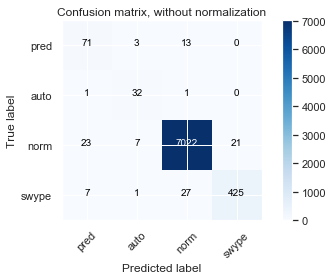

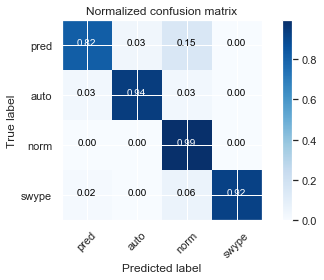

In [34]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# ITE analysis

### Intelligent Text Entry Methods

- Make different user groups (swype, autocorrect, prediction, autocorrect + prediction, none)
- Distribution of intelligent support methods (how many users use what)
(comparison:  only <4.5 % of entered text was done by gestures [2], whatever exactly that means…)
- Comparison of performance, error, backspacing, of the different groups (maybe boxplots would be good here?)
(comparison to [2]: . "The ratio of “delete” presses was significantly higher for people who used auto correction (N = 16, M = 0.11, SD = 0.04) than for those who did not (N = 14, M = 0.06, SD = 0.02) (Mann-Whitney U test, U = 164, p < 0.005).")

#### Swype:
- for users that use swype, ratio of swyped words versus non-swyped words:
analyzed first per sentence and then averaged across the sentences
- across users, percentage of swyped words versus overall performance and errors and number of backspaces (correlation and graph)

#### Autocorrection  
- Percentage of autocorrected words per user (per sentence, average across all sentences)
correlation of percentage of autocorrected words with performance and error rate
- Metrics from [2]
-The mean length of corrected words (comparison to [2]:  5.16 characters prior to correction, 5.24 afterwards i). 
- Did correction change the length? (comparison to [2]: in 91.6% of cases, correction left the length unchanged, in 7.1% of cases it added at least one character, and 1.2% corrections removed at least one. 
- Mean edit distance (comparison to [2]: 1.27)

#### Prediction:
- Percentage of predicted words per user (per sentence, average across all sentences)
- correlation of percentage of predicted words with performance and error rate
- keystroke savings = edit distance between prediction and previous input string
- Automation benefit = Keystroke savings / final input length
- For comparison:9.44% for an "extroverted keyboard" and 4.66% for an "ambiverted keyboard", see [5] not sure though that their definition of tap savings is comparable… 
- Metrics from [2] 
- ratio of prediction selection = percentage of prediction keystroke versus all keystrokes (comparison to [2]: mean 1.6%, max 9.4%



In [57]:
P_SAMPLE = 'select * from VALID_PARTICIPANTS'


p_sample = pd.read_sql_query(P_SAMPLE, engine)
p_sample.fillna(0, inplace=True)
p_sample.head()

PARTICIPANT_ID      IP_ADDRESS  \
0             629   110.54.203.10   
1             632  115.164.40.232   
2             669   122.8.244.180   
3             673   37.219.99.214   
4             674   118.93.226.60   

                                             BROWSER BROWSER_LANGUAGE  DEVICE  \
0  Mozilla/5.0 (Linux; Android 5.0.2; vivo Y51 Bu...            en-US  mobile   
1  Mozilla/5.0 (Linux; Android 7.0; vivo 1713 Bui...            en-US  mobile   
2  Mozilla/5.0 (Linux; Android 6.0; LG-V495 Build...   en-US,en;q=0.8  mobile   
3  Mozilla/5.0 (Linux; Android 6.0; HTC One X9 du...   en-US,en;q=0.9  mobile   
4  Mozilla/5.0 (iPhone; CPU iPhone OS 11_4_1 like...            en-us  mobile   

   SCREEN_W  SCREEN_H  AGE  GENDER  HAS_TAKEN_TYPING_COURSE     ...       \
0       360       640   20    male                        0     ...        
1       360       640   24    male                        0     ...        
2       601       962   16  female                        0     ...        
3       360       640   27  female                        0     ...        
4       375       667   24  female                        0     ...        

  TYPE_TEST_LANG  P_KPD   P_IKI P_BSP P_ECPC P_UILEN P_KSPC ITE_SWYPE  \
0    sometimes 21.981 188.929 3.467  0.084  42.733  1.163     0.034   
1      usually 14.406 199.738 1.000  0.024  47.133  1.323     0.061   
2      usually 22.416 168.124 0.000  0.000  38.200  1.127     0.116   
3      usually 15.132 120.704 0.000  0.000  41.667  1.061     0.017   
4       always 21.390 137.334 1.600  0.047  38.467  1.011     0.119   

  ITE_PREDICT ITE_AUTOCORR  
0       0.034        0.000  
1       0.157        0.013  
2       0.037        0.046  
3       0.186        0.187  
4       0.246        0.007  

[5 rows x 29 columns]

In [58]:
len(p_sample)

37606

In [59]:
columns = ['PARTICIPANT_ID', 'IP_ADDRESS', 'GENDER', 'WPM', 'ERROR_RATE', 'USING_FEATURES', 
           'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_UILEN', 'P_KSPC', 
           'ITE_SWYPE', 'ITE_PREDICT', 'ITE_AUTOCORR']

p_sample = p_sample[columns]
p_sample['REP_SWYPE'] = p_sample.USING_FEATURES.apply(lambda x: 1 if x.find('swipe') != -1 else 0)

# Find participants whi have not reported using Swype, but ITE_SWYPE != 0. For them assignt ITE_PRED += ITE_SWYPE
reassign_indxs = p_sample[(p_sample['REP_SWYPE']==0) & (p_sample['ITE_SWYPE'] !=0)].index
p_sample.loc[reassign_indxs, 'ITE_PREDICT'] = p_sample.loc[reassign_indxs, 'ITE_PREDICT'] + p_sample.loc[reassign_indxs, 'ITE_SWYPE']
p_sample.loc[reassign_indxs, 'ITE_SWYPE'] = 0


In [4]:
TS_SAMPLE = 'select * from FIRST_15_TEST_SECTIONS'
ts_sample = pd.read_sql_query(TS_SAMPLE, engine)
ts_sample.fillna(0, inplace=True)
ts_sample.head()

TEST_SECTION_ID  SENTENCE_ID  PARTICIPANT_ID  \
0             2512         1269             629   
1             2513         1365             629   
2             2515          401             629   
3             2516          349             629   
4             2520          448             629   

                                          USER_INPUT  INPUT_TIME  \
0              We have lost not just a great friend.       10886   
1                           I do not want to repeat.        6497   
2  Rookie Kevin Swayne will move into the startin...       18116   
3           Theresa, I changed the CIG fuel rate to.       13687   
4                      Weinke could have a big game.        9766   

   EDIT_DISTANCE  ERROR_RATE    WPM  INPUT_LENGTH  ERROR_LEN      ...       \
0              0       0.000 39.684            36         37      ...        
1              0       0.000 42.481            23         24      ...        
2              0       0.000 35.769            54         55      ...        
3              0       0.000 34.193            39         40      ...        
4              0       0.000 34.405            28         29      ...        

   TS_UILEN  TS_KS TS_KSPC  N_SWYP  N_PRED  N_AUTO  PR_SWYP  PR_PRED  PR_AUTO  \
0        37     47   1.270   1.000   1.000   0.000    0.125    0.125    0.000   
1        24     24   1.000   1.000   1.000   0.000    0.167    0.167    0.000   
2        55     59   1.073   0.000   0.000   0.000    0.000    0.000    0.000   
3        40     42   1.050   0.000   0.000   0.000    0.000    0.000    0.000   
4        29     39   1.345   0.000   0.000   0.000    0.000    0.000    0.000   

   TS_NUM_WORDS  
0         8.000  
1         6.000  
2         9.000  
3         8.000  
4         6.000  

[5 rows x 27 columns]

In [5]:
reassing_partic = p_sample.loc[reassign_indxs, 'PARTICIPANT_ID'].values
reassign_ts_indxs = ts_sample[ts_sample.PARTICIPANT_ID.isin(reassing_partic)].index
ts_sample.loc[reassign_ts_indxs, 'PR_PRED'] = ts_sample.loc[reassign_ts_indxs, 'PR_PRED'] + ts_sample.loc[reassign_ts_indxs, 'PR_SWYP']
ts_sample.loc[reassign_ts_indxs, 'PR_SWYP'] = 0

## Test section-level analysis

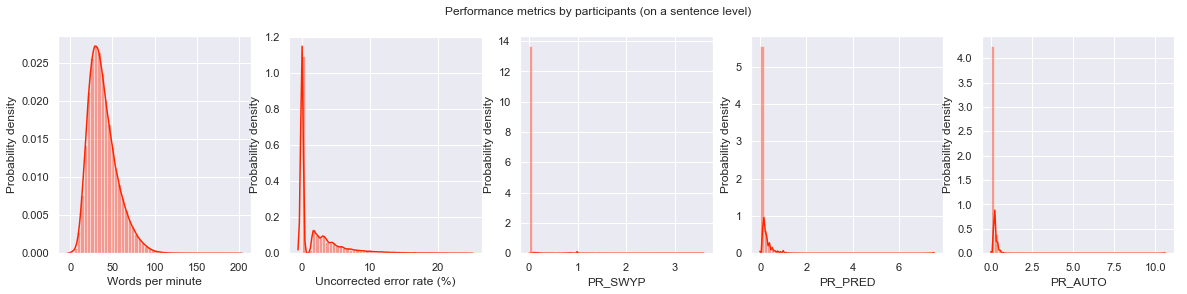

In [6]:
# Performance 
ROWS = 1
COLS = 5

paper_metrics = ['WPM', 'ERROR_RATE', 'PR_SWYP', 'PR_PRED', 'PR_AUTO']
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,4))
plt.suptitle('Performance metrics by participants (on a sentence level)')
for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.distplot(ts_sample[f], ax=axs[i])
    axs[i].set(ylabel="Probability density")
axs[0].set(xlabel='Words per minute')
axs[1].set(xlabel='Uncorrected error rate (%)')

plt.savefig('ite_distrib.png', bbox_inches='tight')

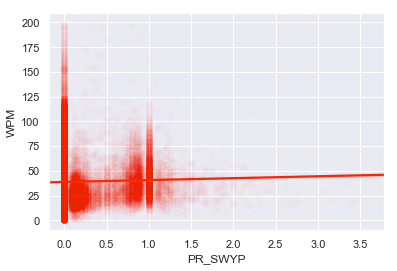

In [7]:
sns.regplot('PR_SWYP', 'WPM', data=ts_sample, scatter_kws={"alpha":0.01},)

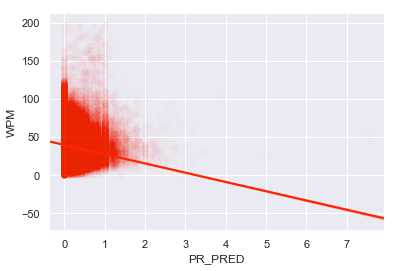

In [8]:
sns.regplot('PR_PRED', 'WPM', data=ts_sample, scatter_kws={"alpha":0.01},)

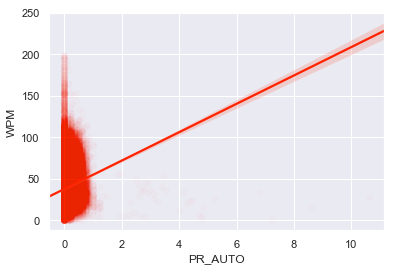

In [9]:
sns.regplot('PR_AUTO', 'WPM', data=ts_sample, scatter_kws={"alpha":0.01},)

## Participant-level analysis

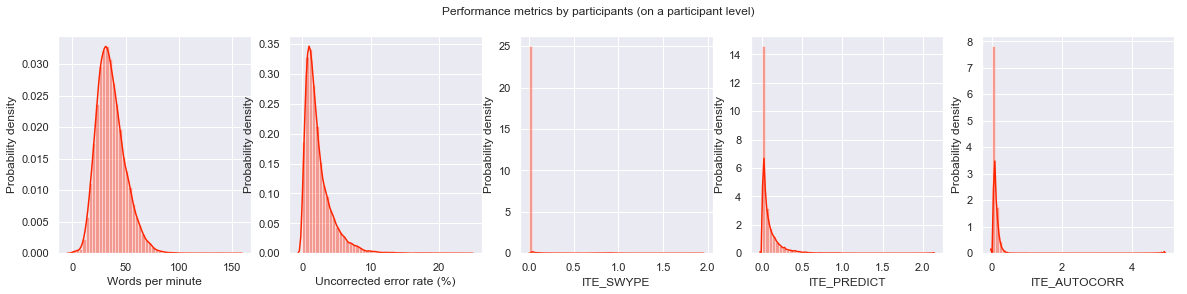

In [10]:
# Performance 
ROWS = 1
COLS = 5

paper_metrics = ['WPM', 'ERROR_RATE', 'ITE_SWYPE', 'ITE_PREDICT', 'ITE_AUTOCORR']
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,4))
plt.suptitle('Performance metrics by participants (on a participant level)')
for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.distplot(p_sample[f], ax=axs[i])
    axs[i].set(ylabel="Probability density")
axs[0].set(xlabel='Words per minute')
axs[1].set(xlabel='Uncorrected error rate (%)')

plt.savefig('ite_distrib.png', bbox_inches='tight')

[Text(0.5,0,'Uncorrected error rate (%)')]

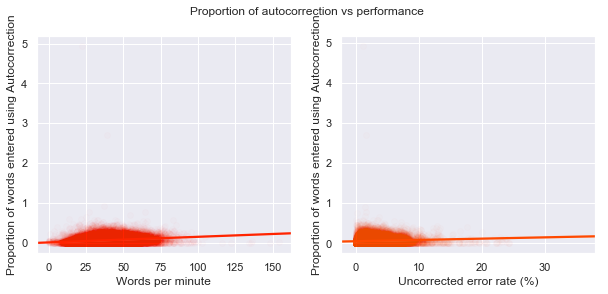

In [11]:
ROWS = 1
COLS = 2
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Proportion of autocorrection vs performance')
paper_metrics = ['WPM', 'ERROR_RATE']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_sample[f], y='ITE_AUTOCORR', data=p_sample, order=1, scatter_kws={"alpha":0.01}, ax=axs[i])
    axs[i].set(ylabel="Proportion of words entered using Autocorrection")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
#axs[0].set(ylim=[0,0.1])
#axs[1].set(ylim=[0,0.1])
       
#plt.savefig('swype_vs_performance.png', bbox_inches='tight')

[Text(0.5,0,'Uncorrected error rate (%)')]

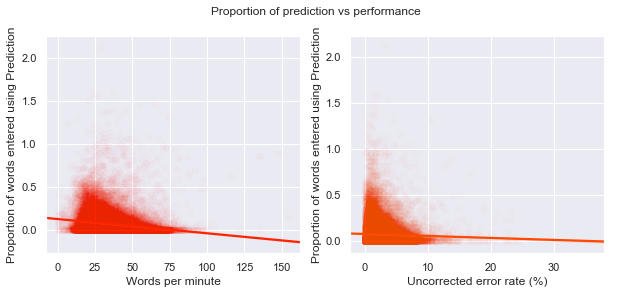

In [12]:
ROWS = 1
COLS = 2
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Proportion of prediction vs performance')
paper_metrics = ['WPM', 'ERROR_RATE']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_sample[f], y='ITE_PREDICT', data=p_sample, order=1, scatter_kws={"alpha":0.01}, ax=axs[i])
    axs[i].set(ylabel="Proportion of words entered using Prediction")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
#axs[0].set(ylim=[0,0.1])
#axs[1].set(ylim=[0,0.1])
       
#plt.savefig('swype_vs_performance.png', bbox_inches='tight')

[Text(0.5,0,'Uncorrected error rate (%)')]

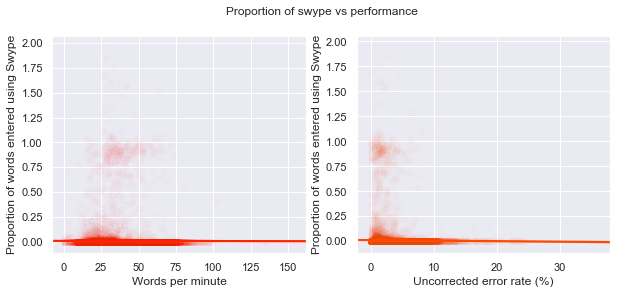

In [13]:
ROWS = 1
COLS = 2
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(10,4))
plt.suptitle('Proportion of swype vs performance')
paper_metrics = ['WPM', 'ERROR_RATE']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_sample[f], y='ITE_SWYPE', data=p_sample, order=1, scatter_kws={"alpha":0.01}, ax=axs[i])
    axs[i].set(ylabel="Proportion of words entered using Swype")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
#axs[0].set(ylim=[0,0.1])
#axs[1].set(ylim=[0,0.1])
       
#plt.savefig('swype_vs_performance.png', bbox_inches='tight')

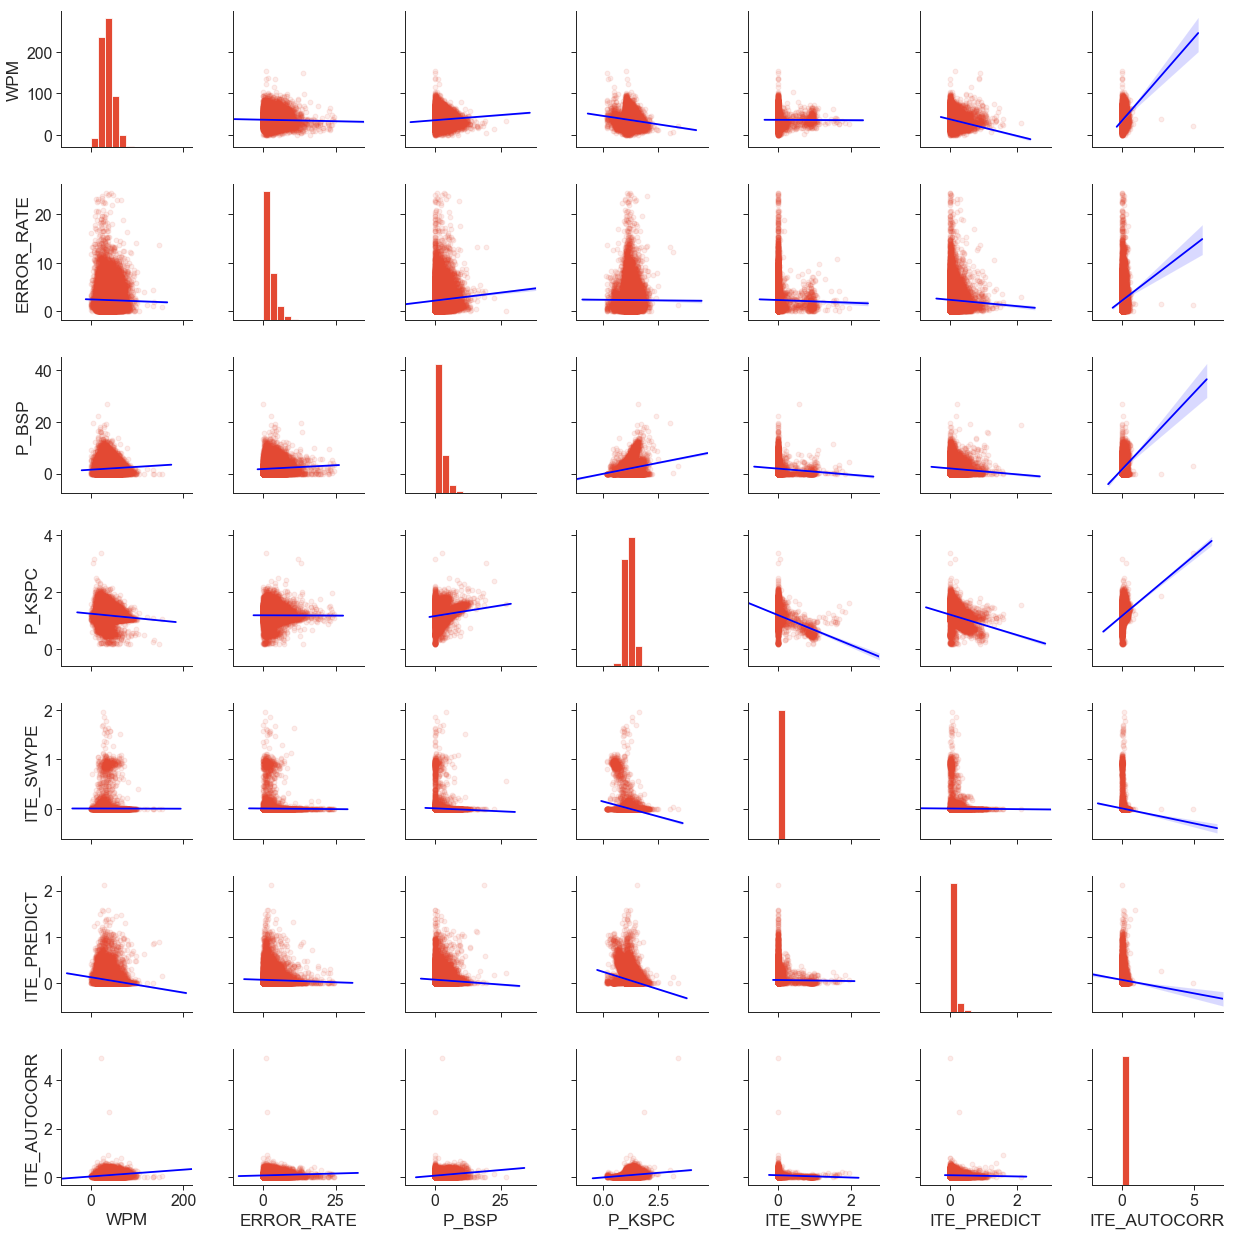

In [97]:
sns.set_palette('RdYlGn')
metrics = ['WPM', 'ERROR_RATE', 'P_BSP', 'P_KSPC', 'ITE_SWYPE', 'ITE_PREDICT', 'ITE_AUTOCORR']
sns.pairplot(p_sample[metrics], plot_kws={'scatter_kws':{'color':'gray'}, 'line_kws':{'color':'blue'}, 'scatter_kws': {'alpha': 0.1}} , kind="reg")
plt.savefig('pairplots.png', bbox_inches='tight')

In [118]:
p_sample[['WPM', 'ERROR_RATE', 'P_BSP', 'P_KSPC', 'ITE_SWYPE', 'ITE_AUTOCORR', 'ITE_PREDICT']].corr()

WPM  ERROR_RATE  P_BSP  P_KSPC  ITE_SWYPE  ITE_AUTOCORR  \
WPM           1.000      -0.023  0.075  -0.114     -0.003         0.238   
ERROR_RATE   -0.023       1.000  0.062  -0.004     -0.012         0.086   
P_BSP         0.075       0.062  1.000   0.160     -0.053         0.237   
P_KSPC       -0.114      -0.004  0.160   1.000     -0.252         0.180   
ITE_SWYPE    -0.003      -0.012 -0.053  -0.252      1.000        -0.053   
ITE_AUTOCORR  0.238       0.086  0.237   0.180     -0.053         1.000   
ITE_PREDICT  -0.182      -0.037 -0.070  -0.233     -0.008        -0.038   

              ITE_PREDICT  
WPM                -0.182  
ERROR_RATE         -0.037  
P_BSP              -0.070  
P_KSPC             -0.233  
ITE_SWYPE          -0.008  
ITE_AUTOCORR       -0.038  
ITE_PREDICT         1.000

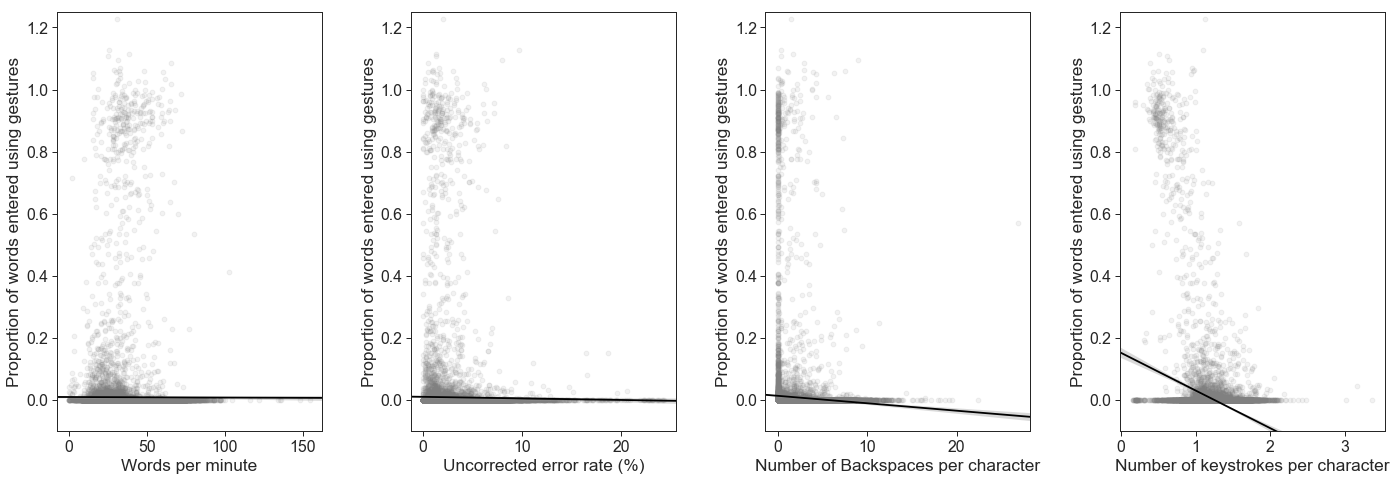

In [114]:
ROWS = 1
COLS = 4
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20, 7))
#plt.suptitle('Proportion of gestures vs performance')
paper_metrics = ['WPM', 'ERROR_RATE', 'P_BSP', 'P_KSPC']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_sample[f], y='ITE_SWYPE', data=p_sample, order=1, color='black', scatter_kws={"alpha":0.1, "color":'grey'}, ax=axs[i])
    axs[i].set(ylabel="Proportion of words entered using gestures")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
axs[2].set(xlabel="Number of Backspaces per character")
axs[3].set(xlabel="Number of keystrokes per character")

plt.tight_layout()
axs[0].set(ylim=[-0.1,1.25])
axs[1].set(ylim=[-0.1,1.25])
axs[2].set(ylim=[-0.1,1.25])
axs[3].set(ylim=[-0.1,1.25])
       
plt.savefig('swype_vs_performance.png', bbox_inches='tight')

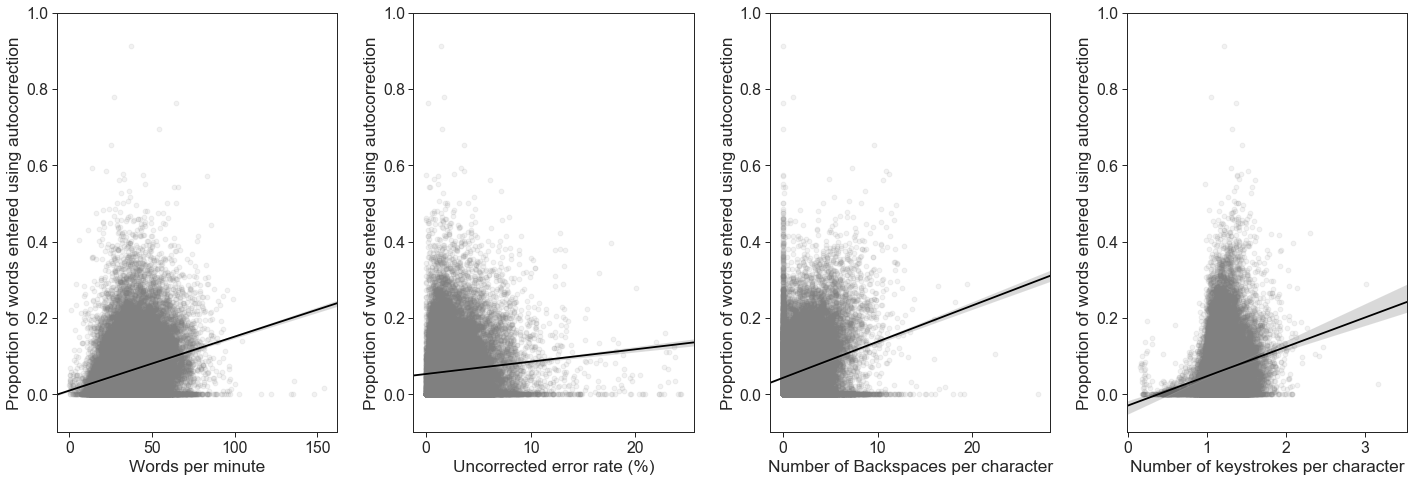

In [113]:
ROWS = 1
COLS = 4
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20, 7))
#plt.suptitle('Proportion of gestures vs performance')
paper_metrics = ['WPM', 'ERROR_RATE', 'P_BSP', 'P_KSPC']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_sample[f], y='ITE_AUTOCORR', data=p_sample, order=1, color='black', scatter_kws={"alpha":0.1, "color":'grey'}, ax=axs[i])
    axs[i].set(ylabel="Proportion of words entered using autocorrection")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
axs[2].set(xlabel="Number of Backspaces per character")
axs[3].set(xlabel="Number of keystrokes per character")

plt.tight_layout()
axs[0].set(ylim=[-0.1,1])
axs[1].set(ylim=[-0.1,1])
axs[2].set(ylim=[-0.1,1])
axs[3].set(ylim=[-0.1,1])
       
plt.savefig('auto_vs_performance.png', bbox_inches='tight')

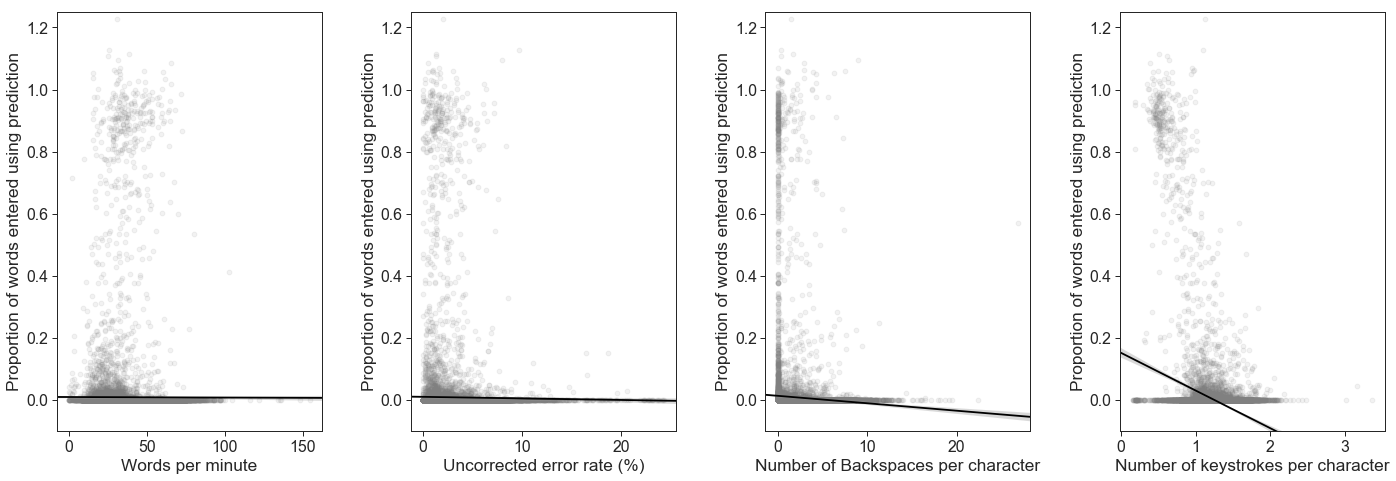

In [112]:
ROWS = 1
COLS = 4
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20, 7))
#plt.suptitle('Proportion of gestures vs performance')
paper_metrics = ['WPM', 'ERROR_RATE', 'P_BSP', 'P_KSPC']

for i in range(0,len(paper_metrics)): 
    f = paper_metrics[i]
    rown = 0
    coln = i
    sns.regplot(x=p_sample[f], y='ITE_SWYPE', data=p_sample, order=1, color='black', scatter_kws={"alpha":0.1, "color":'grey'}, ax=axs[i])
    axs[i].set(ylabel="Proportion of words entered using prediction")

axs[0].set(xlabel="Words per minute")
axs[1].set(xlabel="Uncorrected error rate (%)")
axs[2].set(xlabel="Number of Backspaces per character")
axs[3].set(xlabel="Number of keystrokes per character")

plt.tight_layout()
axs[0].set(ylim=[-0.1,1.25])
axs[1].set(ylim=[-0.1,1.25])
axs[2].set(ylim=[-0.1,1.25])
axs[3].set(ylim=[-0.1,1.25])
       
plt.savefig('pred_vs_performance.png', bbox_inches='tight')

# US sample

In [60]:
unique_ips = p_sample.IP_ADDRESS.unique()
unique_ips = pd.Series(unique_ips, index = unique_ips)
p_sample['DET_COUNTRY'] = p_sample.IP_ADDRESS.map(unique_ips.apply(get_country_iso))


In [61]:
female_US = p_sample[(p_sample.DET_COUNTRY=='US') & (p_sample.GENDER=='female')].sample(frac=0.318820)
male_US = p_sample[(p_sample.DET_COUNTRY=='US') & (p_sample.GENDER=='male')]
participants_US = pd.concat([female_US, male_US], axis=0)

## Participant-level Boxplot WPM comparisons

In [66]:
def categorize_ite(row):
    if row['ITE_SWYPE']==0 and row['ITE_PREDICT']==0 and row['ITE_AUTOCORR']==0:
        return 'norm'
    elif row['ITE_SWYPE']!=0 and row['ITE_PREDICT']==0 and row['ITE_AUTOCORR']==0:
        return 'swype'
    elif row['ITE_SWYPE']==0 and row['ITE_PREDICT']!=0 and row['ITE_AUTOCORR']==0:
        return 'pred'
    elif row['ITE_SWYPE']==0 and row['ITE_PREDICT']==0 and row['ITE_AUTOCORR']!=0:
        return 'auto'    
    elif row['ITE_SWYPE']!=0 and row['ITE_PREDICT']!=0 and row['ITE_AUTOCORR']==0:
        return 'swype,pred'
    elif row['ITE_SWYPE']==0 and row['ITE_PREDICT']!=0 and row['ITE_AUTOCORR']!=0:
        return 'pred,auto'
    elif row['ITE_SWYPE']!=0 and row['ITE_PREDICT']==0 and row['ITE_AUTOCORR']!=0:
        return 'swype,auto'
    else:
        return 'mix'
    
    
participants_US['ITE_CAT'] = participants_US.apply(categorize_ite, axis=1 )   


p_sample['ITE_CAT'] = p_sample.apply(categorize_ite, axis=1 )   

pd.unique(p_sample['ITE_CAT'])



array(['pred', 'pred,auto', 'mix', 'auto', 'swype,pred', 'norm', 'swype',
       'swype,auto'], dtype=object)

In [63]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

                            OLS Regression Results                            
Dep. Variable:                    WPM   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     364.9
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        18:35:54   Log-Likelihood:            -1.4922e+05
No. Observations:               37606   AIC:                         2.984e+05
Df Residuals:                   37598   BIC:                         2.985e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

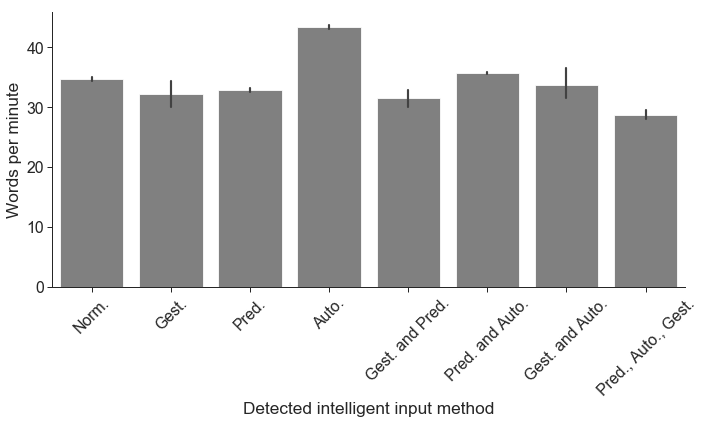

In [115]:
#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
order = ['norm', 'swype', 'pred', 'auto', 'swype,pred', 'pred,auto','swype,auto','mix']
g = sns.catplot(x="ITE_CAT", y="WPM", kind='bar', data=p_sample, aspect=2, color='grey', order=order);
g.set_xticklabels(["Norm.", "Gest.", "Pred.", "Auto.", "Gest. and Pred.", "Pred. and Auto.", "Gest. and Auto.", "Pred., Auto., Gest."])
g.set_xticklabels(rotation=45)
plt.xlabel("Detected intelligent input method")
plt.ylabel("Words per minute")
plt.savefig('ite_wpm.png', bbox_inches='tight') 

results = ols('WPM ~ C(ITE_CAT)', data=p_sample).fit() #Specify C for Categorical
print(results.summary())

In [120]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)


MultiComp = MultiComparison(p_sample.WPM,
                            p_sample.ITE_CAT)

print(MultiComp.tukeyhsd().summary())

   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
  group1     group2   meandiff  lower    upper   reject
-------------------------------------------------------
   auto       mix     -14.6183 -16.0104 -13.2263  True 
   auto       norm    -8.6191  -9.3649  -7.8732   True 
   auto       pred    -10.5346 -11.3014 -9.7678   True 
   auto    pred,auto  -7.6902  -8.2747  -7.1057   True 
   auto      swype    -11.1382 -14.4799 -7.7965   True 
   auto    swype,auto -9.6224  -13.5544 -5.6905   True 
   auto    swype,pred -11.859  -13.9649 -9.7532   True 
   mix        norm     5.9993   4.6003   7.3982   True 
   mix        pred     4.0837   2.6735   5.4939   True 
   mix     pred,auto   6.9281   5.6081   8.2481   True 
   mix       swype     3.4801  -0.0649   7.0252  False 
   mix     swype,auto  4.9959   0.8897   9.1021   True 
   mix     swype,pred  2.7593   0.3436   5.1749   True 
   norm       pred    -1.9155  -2.6948  -1.1362   True 
   norm    pred,auto   0.9288   0.3281   1.5296 

In [82]:
p_sample.groupby('ITE_CAT').agg({ 'P_BSP':['mean','std']})

P_BSP      
            mean   std
ITE_CAT               
auto       1.981 1.708
mix        1.081 1.706
norm       2.064 2.056
pred       1.575 1.999
pred,auto  1.945 1.977
swype      0.907 1.604
swype,auto 0.705 1.207
swype,pred 1.474 2.585

In [69]:
participants_US.ITE_CAT.value_counts(normalize=True)

pred,auto    0.648
auto         0.182
pred         0.082
norm         0.051
mix          0.022
swype,pred   0.008
swype        0.003
swype,auto   0.003
Name: ITE_CAT, dtype: float64

In [121]:
p_sample.tail()

PARTICIPANT_ID       IP_ADDRESS  GENDER    WPM  ERROR_RATE  \
37601          274107   113.23.155.253  female 61.682       1.802   
37602          274109    216.66.93.244    male 31.198       0.638   
37603          274116  113.210.203.104    male 42.801       2.326   
37604          274128    115.178.239.7    male 47.055       0.728   
37605          274142      105.12.3.29  female 39.407       1.101   

           USING_FEATURES  P_KPD  P_IKI  P_BSP  P_ECPC  P_UILEN  P_KSPC  \
37601              ["no"]  5.144 33.553  0.000   0.000   36.733   1.273   
37602  ["autocorrection"] 11.781 32.085  0.000   0.000   41.733   1.554   
37603              ["no"]  9.255 35.059  0.000   0.000   37.000   1.324   
37604              ["no"]  3.471 48.304  1.400   0.032   45.600   1.062   
37605              ["no"]  4.750 50.689  0.000   0.000   42.267   1.141   

       ITE_SWYPE  ITE_PREDICT  ITE_AUTOCORR  REP_SWYPE DET_COUNTRY    ITE_CAT  
37601      0.000        0.000         0.049          0          MY       auto  
37602      0.000        0.051         0.052          0          US  pred,auto  
37603      0.000        0.162         0.031          0          MY  pred,auto  
37604      0.000        0.000         0.000          0          ID       norm  
37605      0.000        0.185         0.037          0          ZA  pred,auto

## Ratio of swyped versus non-swyped words 

In [93]:
p_sample.ITE_PREDICT.describe()

count   37606.000
mean        0.069
std         0.120
min         0.000
25%         0.000
50%         0.022
75%         0.084
max         2.123
Name: ITE_PREDICT, dtype: float64

In [ ]:
p_sample.ITE_SWYPE